# 白盒攻击

- 所需数据集：FashionMNIST
- 分类模型：ResNet34，测试集准确率93.71%

## 基于I-FGSM的攻击

### 寻找攻击学习率Epsilon的最佳值
- 参考文献：[Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572)
- 本项目使用的算法与原始FGSM已不同，本项目迭代增加梯度扰动，且进行定向攻击，应当是拟梯度方向扰动
- I-FGSM算法中需要实验确定超参数Epsilon的值，以确定每次扰动的最佳步长
- 下面的代码块实验了Epsilon取值范围为0.01-0.5所对应的不同攻击成功率
- 攻击迭代次数控制在100次以内
- 最终实验表明**Epsilon取0.005**，攻击成功率最高
- 同时还要控制攻击所带来的改动不是非常剧烈，综合判断最优Epsilon取值
- 在分类器成功分类的测试集上**随机抽取2000张图像**，攻击**成功率为15.7%**
- Epsilon选取规律与原始算法不

cuda


C:\Users\01\AppData\Local\Temp\ipykernel_13048\4077296962.py:36: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen/core/TensorBody.h:491.)
  if perturbed_image.grad is None:


Epsilon: 0.01	Attack progress: 1000 / 10000	success:138
Epsilon: 0.01	Attack progress: 2000 / 10000	success:286
Epsilon: 0.01	Attack progress: 3000 / 10000	success:430
Epsilon: 0.01	Attack progress: 4000 / 10000	success:557
Epsilon: 0.01	Attack progress: 5000 / 10000	success:705
Epsilon: 0.01	Attack progress: 6000 / 10000	success:861
Epsilon: 0.01	Attack progress: 7000 / 10000	success:1003
Epsilon: 0.01	Attack progress: 8000 / 10000	success:1143
Epsilon: 0.01	Attack progress: 9000 / 10000	success:1285
Epsilon: 0.01	Attack success rate: 0.1433
Epsilon: 0.02	Attack progress: 1000 / 10000	success:136
Epsilon: 0.02	Attack progress: 2000 / 10000	success:269
Epsilon: 0.02	Attack progress: 3000 / 10000	success:416
Epsilon: 0.02	Attack progress: 4000 / 10000	success:551
Epsilon: 0.02	Attack progress: 5000 / 10000	success:716
Epsilon: 0.02	Attack progress: 6000 / 10000	success:866
Epsilon: 0.02	Attack progress: 7000 / 10000	success:1013
Epsilon: 0.02	Attack progress: 8000 / 10000	success:1155
E

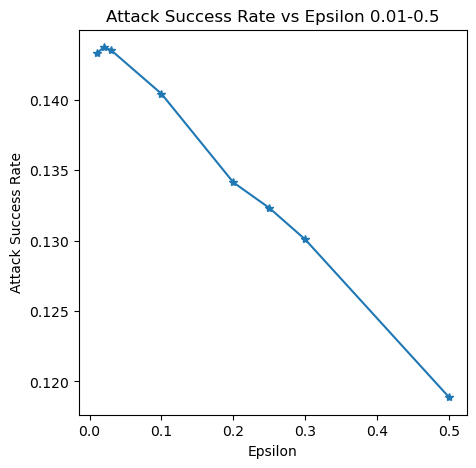

In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.2860,), std=(0.3530,))
    ])
# 加载测试集
test_data = torchvision.datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

# 定义攻击函数
def fgsm_attack(image, epsilon, max_iter, model, target):
    if epsilon == 0:
            return False, perturbed_image
    perturbed_image = image
    attack_target = (target + 1) % 10
    # 迭代更新扰动值
    for i in range(max_iter):
        # 计算梯度并更新扰动值
        # perturbed_image.requires_grad = True
        perturbed_image.requires_grad_(True)
        output = model(perturbed_image)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, attack_target)
        model.zero_grad()
        loss.backward()
        # print(perturbed_image.grad.size())
        if epsilon == 0:
            return False, perturbed_image
        if perturbed_image.grad is None:
            return False, perturbed_image
        data_grad = perturbed_image.grad.data
        perturbed_image = perturbed_image - epsilon * data_grad.sign()
        # 限制像素值范围在[0,1]
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        # 如果扰动图像已经被误分类，停止攻击
        if model(perturbed_image).max(1, keepdim=True)[1] == attack_target:
            return True, perturbed_image
    return False, perturbed_image

# 定义测试函数
def test(model, device, test_loader, epsilon):
    model.eval()
    success_num = 0
    correct = 0
    adv_examples = []
    for data, target in test_loader:
        # 找到被分类正确的图像
        data, target = data.to(device), target.to(device)
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        if init_pred.item() != target.item():
            continue
        correct += 1

        success, perturbed_data = fgsm_attack(image=data, epsilon=epsilon, max_iter=100, model=model, target=target)
        if success:
            success_num += 1
            adv_examples.append((data, perturbed_data, target))
        # 打印进度信息
        if correct % 1000 == 0:
            print(f"Epsilon: {epsilon}\tAttack progress: {correct} / {len(test_loader)}\tsuccess:{success_num}")
        # if correct == 2000:
            # break
    # 计算攻击成功率
    attack_acc = success_num / float(correct)
    print(f"Epsilon: {epsilon}\tAttack success rate: {attack_acc:.4f}")
    return attack_acc, adv_examples

# 设置攻击参数
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(device)
epsilons = [.01, .02, .03, .1, .2, .25, .3, .5]
attack_accs = []
examples = []

# 加载模型
model = torchvision.models.resnet34(weights=None, num_classes=10)
model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = nn.Linear(model.fc.in_features, 10)  # 更改最后一层全连接层
model.load_state_dict(torch.load('../checkpoints/checkpoint-60-93.71.pt', map_location=device))
model.to(device)
# 对模型进行测试和攻击

for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    attack_accs.append(acc)
    examples.append(ex)
    if not os.path.exists('../attack_data'):
        os.makedirs('../attack_data')    
    torch.save(ex, f'../attack_data/eps-{eps:.2f}-ASR-{acc:.2f}.pt')


torch.save(examples, '../attack_data/attack_examples.pt')


plt.figure(figsize=(5,5))
plt.plot(epsilons, attack_accs, "*-")
# plt.yticks(np.arange(0, 1.1, step=0.1))
# plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Attack Success Rate vs Epsilon 0.01-0.5")
plt.xlabel("Epsilon")
plt.ylabel("Attack Success Rate")
plt.show()

![Attack Success Rate vs Epsilon 0.01-0.5](../images/White%20Attack%20Success%20Rate%20vs%20Epsilon%200.01-0.5.png)

cuda


C:\Users\01\AppData\Local\Temp\ipykernel_13048\143563758.py:36: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen/core/TensorBody.h:491.)
  if perturbed_image.grad is None:


Epsilon: 0.001	Attack progress: 1000 / 10000	success:139
Epsilon: 0.001	Attack progress: 2000 / 10000	success:280
Epsilon: 0.001	Attack progress: 3000 / 10000	success:409
Epsilon: 0.001	Attack progress: 4000 / 10000	success:549
Epsilon: 0.001	Attack progress: 5000 / 10000	success:707
Epsilon: 0.001	Attack progress: 6000 / 10000	success:853
Epsilon: 0.001	Attack progress: 7000 / 10000	success:984
Epsilon: 0.001	Attack progress: 8000 / 10000	success:1120
Epsilon: 0.001	Attack progress: 9000 / 10000	success:1275
Epsilon: 0.001	Attack success rate: 0.1425
Epsilon: 0.002	Attack progress: 1000 / 10000	success:151
Epsilon: 0.002	Attack progress: 2000 / 10000	success:264
Epsilon: 0.002	Attack progress: 3000 / 10000	success:410
Epsilon: 0.002	Attack progress: 4000 / 10000	success:554
Epsilon: 0.002	Attack progress: 5000 / 10000	success:693
Epsilon: 0.002	Attack progress: 6000 / 10000	success:839
Epsilon: 0.002	Attack progress: 7000 / 10000	success:989
Epsilon: 0.002	Attack progress: 8000 / 1000

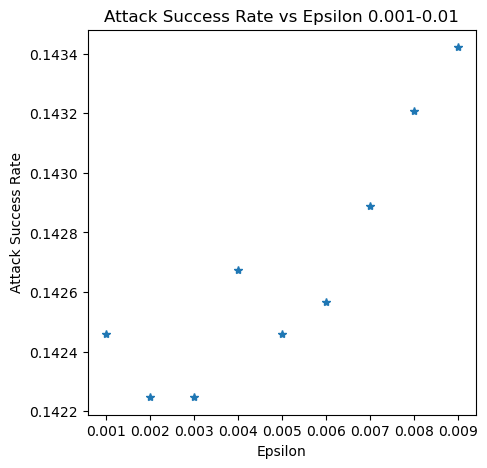

In [2]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.2860,), std=(0.3530,))
    ])
# 加载测试集
test_data = torchvision.datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

# 定义攻击函数
def fgsm_attack(image, epsilon, max_iter, model, target):
    if epsilon == 0:
            return False, perturbed_image
    perturbed_image = image
    attack_target = (target + 1) % 10
    # 迭代更新扰动值
    for i in range(max_iter):
        # 计算梯度并更新扰动值
        # perturbed_image.requires_grad = True
        perturbed_image.requires_grad_(True)
        output = model(perturbed_image)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, attack_target)
        model.zero_grad()
        loss.backward()
        # print(perturbed_image.grad.size())
        if epsilon == 0:
            return False, perturbed_image
        if perturbed_image.grad is None:
            return False, perturbed_image
        data_grad = perturbed_image.grad.data
        perturbed_image = perturbed_image - epsilon * data_grad.sign()
        # 限制像素值范围在[0,1]
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        # 如果扰动图像已经被误分类，停止攻击
        if model(perturbed_image).max(1, keepdim=True)[1] == attack_target:
            return True, perturbed_image
    return False, perturbed_image

# 定义测试函数
def test(model, device, test_loader, epsilon):
    model.eval()
    success_num = 0
    correct = 0
    adv_examples = []
    for data, target in test_loader:
        # 找到被分类正确的图像
        data, target = data.to(device), target.to(device)
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        if init_pred.item() != target.item():
            continue
        correct += 1

        success, perturbed_data = fgsm_attack(image=data, epsilon=epsilon, max_iter=100, model=model, target=target)
        if success:
            success_num += 1
            adv_examples.append((data, perturbed_data, target))
        # 打印进度信息
        if correct % 1000 == 0:
            print(f"Epsilon: {epsilon}\tAttack progress: {correct} / {len(test_loader)}\tsuccess:{success_num}")
        # if correct == 2000:
            # break
    # 计算攻击成功率
    attack_acc = success_num / float(correct)
    print(f"Epsilon: {epsilon}\tAttack success rate: {attack_acc:.4f}")
    return attack_acc, adv_examples

# 设置攻击参数
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(device)
epsilons = [.001, .002, .003, .004, .005, .006, .007, .008, .009]
attack_accs = []
examples = []

# 加载模型
model = torchvision.models.resnet34(weights=None, num_classes=10)
model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = nn.Linear(model.fc.in_features, 10)  # 更改最后一层全连接层
model.load_state_dict(torch.load('../checkpoints/checkpoint-60-93.71.pt', map_location=device))
model.to(device)
# 对模型进行测试和攻击

for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    attack_accs.append(acc)
    examples.append(ex)
    if not os.path.exists('../attack_data'):
        os.makedirs('../attack_data')    
    torch.save(ex, f'../attack_data/eps-{eps:.3f}-ASR-{acc:.3f}.pt')


torch.save(examples, '../attack_data/attack_examples.pt')

plt.figure(figsize=(5,5))
plt.plot(epsilons, attack_accs, "*")
# plt.yticks(np.arange(0, 1.1, step=0.1))
# plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Attack Success Rate vs Epsilon 0.001-0.01")
plt.xlabel("Epsilon")
plt.ylabel("Attack Success Rate")
plt.show()

![Attack Success Rate vs Epsilon 0.001-0.01](../images/White%20Attack%20Success%20Rate%20vs%20Epsilon%200.001-0.01.png)

### 输出攻击成功的样本对比图

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
1347


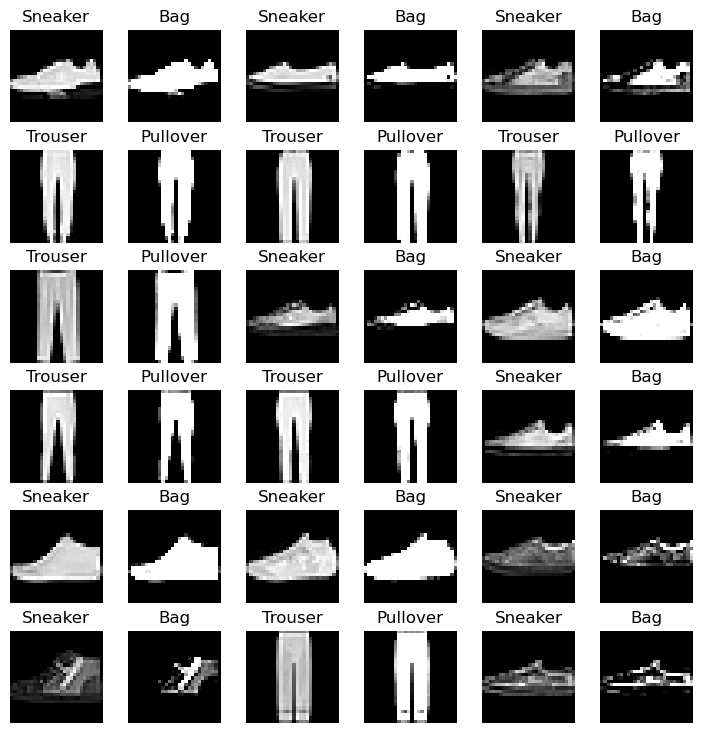

In [5]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import torchvision
import numpy as np
import random

# 加载测试集类别
test_data = torchvision.datasets.FashionMNIST(root='../data', train=False, download=True, transform=transforms.ToTensor())
class_names = list(test_data.classes)
print(class_names)
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
adv_examples = torch.load('../attack_data/eps-0.02-ASR-0.14.pt', map_location=device)
random.seed(21911)
random.shuffle(adv_examples)
print(len(adv_examples))

torch.manual_seed(2023)
fig = plt.figure(figsize=(9, 9))
rows, cols = 6, 6
cnt = 1
for i, (data, perturbed_data, target) in enumerate(adv_examples):
    if cnt > rows * cols:
        break
    random_idx = target.item()
    fig.add_subplot(rows, cols, cnt)
    plt.imshow(data.cpu().detach().numpy().squeeze(), cmap="gray")
    plt.title(class_names[random_idx])
    plt.axis(False)
    # plt.imsave(f'../images/White-N{cnt // 2}-Original-{random_idx}-{class_names[random_idx]}.png', data.cpu().detach().numpy().squeeze())
    cnt += 1

    fig.add_subplot(rows, cols, cnt)
    plt.imshow(perturbed_data.cpu().detach().numpy().squeeze(), cmap="gray")
    attack_target = (random_idx + 1) % 10
    plt.title(class_names[attack_target])
    plt.axis(False)
    # plt.imsave(f'../images/White-N{(cnt-1) // 2}-Perturbed-{attack_target}-{class_names[attack_target]}.png', perturbed_data.cpu().detach().numpy().squeeze())
    cnt += 1
fig.subplots_adjust(hspace=0.3, wspace=0.1)